# CS4035 - Cyber Data Analytics
## Lab 3 

# --- NOTES ---

- Discretize each "netflow" (which is just a single packet/row)
- For each feature, create "bins" for the values (nunique? LabelEncoder?) 
- Concatenate all of these bins into a single feature, such that the dataset only has one feature (confirm?)
- Use k-means to create clusters, and then "utilize the interaction between the features to come up with the features" (optional)


- [Student] "so each row has 1 feature after the concatenation. Since we need a 3-gram, doesn't this essentialy mean that we take row 1, row 2 and row 3 as the first 3-gram? Is then the second 3-gram, row 2, row 3, row 4?"
- [Daniel Vos] "Yes, essentially. You summarize each row with one number/symbol and take 3-grams of these numbers/symbols"

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number :

## Student 1 
### Name: Andrew Gold
### ID: 4995902

## Student 2
### Name: Srinath Jayaraman
### ID: 5049903

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler

In [2]:
df_10 = pd.read_csv("./dataset_10/capture20110818.binetflow")

# Drop the following columns because...
df_10.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_10.drop(index=np.where(df_10['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_10.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_10.reset_index(drop=True, inplace=True)
df_10.head()

,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label
0,3587.569824,tcp,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,3049,978731,245317,flow=From-Normal-V51-Grill
1,198.072739,tcp,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill
2,197.928329,tcp,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill
3,0.000399,udp,147.32.84.170,45807,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek
4,0.000400,udp,147.32.84.170,35380,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek


In [3]:
df_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122199 entries, 0 to 122198
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Dur       122199 non-null  float64
 1   Proto     122199 non-null  object 
 2   SrcAddr   122199 non-null  object 
 3   Sport     122172 non-null  object 
 4   Dir       122199 non-null  object 
 5   DstAddr   122199 non-null  object 
 6   Dport     21003 non-null   object 
 7   State     120972 non-null  object 
 8   TotPkts   122199 non-null  int64  
 9   TotBytes  122199 non-null  int64  
 10  SrcBytes  122199 non-null  int64  
 11  Label     122199 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 11.2+ MB


## 1. Familiarization and discretization task – 1 A4

In [4]:
# First let's see what kind of null values we've got
df_10.isnull().sum()

Dur              0
Proto            0
SrcAddr          0
Sport           27
Dir              0
DstAddr          0
Dport       101196
State         1227
TotPkts          0
TotBytes         0
SrcBytes         0
Label            0
dtype: int64

In [5]:
# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_10.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER

In [6]:
# Remove hexadecimal values from the dataset
df_10.Dport = df_10.Dport.astype('str')
df_10.Sport = df_10.Sport.astype('str')

df_10.Dport = df_10.Dport.apply(lambda x: int(str(x), 0))
df_10.Sport = df_10.Sport.apply(lambda x: int(str(x), 0))

df_10.Dport

0           443
1            80
2            80
3            53
4            53
          ...  
122194    33822
122195    33822
122196       53
122197       53
122198       80
Name: Dport, Length: 122199, dtype: int64

In [7]:
# Let's create a meta-label attribute for each protocol type for botnet activity
df_10['MetaLabel'] = pd.Series()
# df_10_inf.Metalabel.loc[np.where(df_10_inf.Label.str.contains('Normal'))] = 'Normal'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('TCP'))] = 'Botnet-TCP'

df_10


<ipython-input-7-bce7a68da95d>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label,MetaLabel
0,3587.569824,tcp,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,3049,978731,245317,flow=From-Normal-V51-Grill,NaN
1,198.072739,tcp,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill,NaN
2,197.928329,tcp,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,14,924,462,flow=From-Normal-V51-Grill,NaN
3,0.000399,udp,147.32.84.170,45807,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek,NaN
4,0.000400,udp,147.32.84.170,35380,<->,147.32.80.9,53,CON,2,400,74,flow=From-Normal-V51-Stribrek,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122194,0.000743,icmp,147.32.84.164,8,<->,147.32.96.69,33822,ECO,2,196,98,flow=From-Normal-V51-Grill,NaN
122195,0.000913,icmp,147.32.84.164,8,<->,147.32.96.69,33822,ECO,2,196,98,flow=From-Normal-V51-Grill,NaN
122196,0.000414,udp,147.32.84.170,37138,<->,147.32.80.9,53,CON,2,244,81,flow=From-Normal-V51-Stribrek,NaN
122197,0.000322,udp,147.32.84.170,39771,<->,147.32.80.9,53,CON,2,280,81,flow=From-Normal-V51-Stribrek,NaN


In [8]:
# Identify the infected hosts:
inf = df_10.loc[np.where(df_10.Label.str.contains('Botnet'))].SrcAddr.unique()
inf

array(['147.32.84.165', '147.32.84.191', '147.32.84.192', '147.32.84.193',
       '147.32.84.204', '147.32.84.205', '147.32.84.206', '147.32.84.207',
       '147.32.84.208', '147.32.84.209'], dtype=object)

In [9]:
# see the activity level of each infected host
df_10.SrcAddr.loc[np.where(df_10.Label.str.contains('Botnet'))].value_counts()

147.32.84.205    11874
147.32.84.206    11287
147.32.84.204    11159
147.32.84.208    11118
147.32.84.207    10581
147.32.84.191    10454
147.32.84.192    10397
147.32.84.193    10009
147.32.84.209     9894
147.32.84.165     9579
Name: SrcAddr, dtype: int64

<BarContainer object of 10 artists>

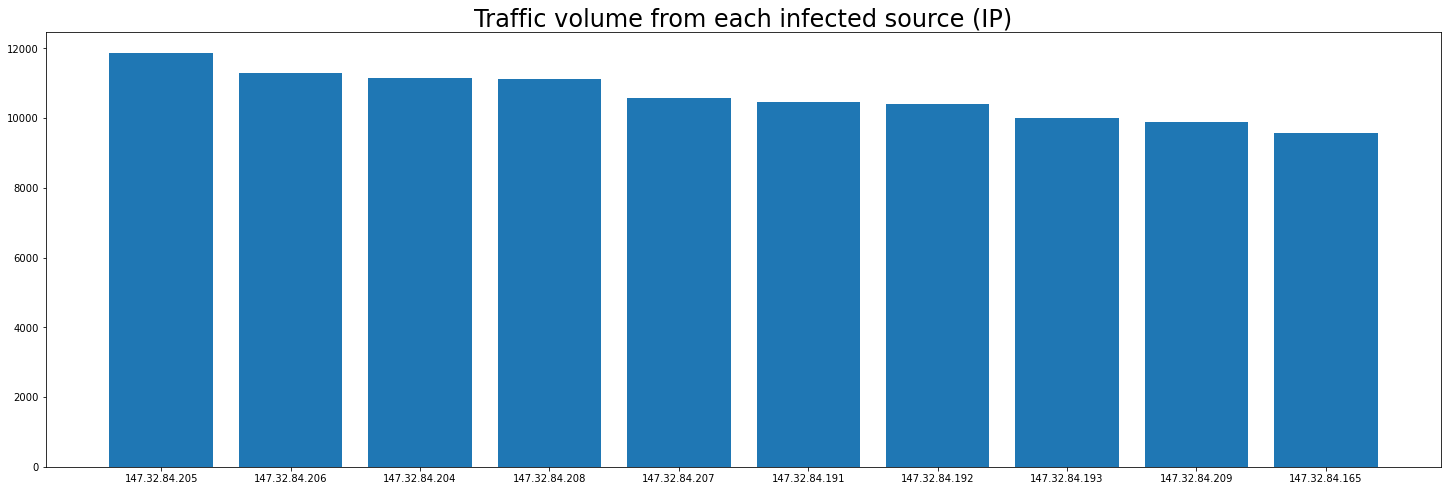

In [10]:
# visualization of amount of traffic from each infected source
fig = plt.figure(figsize=(25,8))
plt.title('Traffic volume from each infected source (IP)', size=24)
plt.bar(df_10.loc[df_10.SrcAddr.isin(inf)].SrcAddr.value_counts().index,
        df_10.loc[df_10.SrcAddr.isin(inf)].SrcAddr.value_counts())

In [11]:
# pick one of the hosts (we'll choose the one with the most traffic)
df_10_inf_1 = df_10.loc[df_10.SrcAddr == '147.32.84.205'].reset_index(inplace=False)
df_10_inf_1

,index,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label,MetaLabel
0,1473,0.000263,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,203,64,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP
1,1474,0.000401,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,590,87,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP
2,1475,0.075763,tcp,147.32.84.205,1027,->,74.125.232.199,80,SRPA_SPA,7,882,629,flow=From-Botnet-V51-6-TCP-HTTP-Google-Net-Est...,Botnet-TCP
3,1478,0.000450,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,479,76,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP
4,1479,3.017135,udp,147.32.84.205,123,->,65.55.56.40,123,INT,2,180,180,flow=From-Botnet-V51-6-UDP-Attempt,Botnet-UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11869,121650,367.653198,tcp,147.32.84.205,1026,->,216.155.130.130,6667,SPA_SPA,55,14273,1662,flow=From-Botnet-V51-6-TCP-CC106-IRC-Not-Encry...,Botnet-TCP
11870,121654,0.000455,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,590,87,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP
11871,121655,0.044163,tcp,147.32.84.205,1028,->,74.125.232.202,80,SRPA_SPA,7,882,629,flow=From-Botnet-V51-6-TCP-HTTP-Google-Net-Est...,Botnet-TCP
11872,121656,0.000412,udp,147.32.84.205,1025,<->,147.32.80.9,53,CON,2,479,76,flow=From-Botnet-V51-6-UDP-DNS,Botnet-UDP


In [12]:
df_10_inf_1.Proto.value_counts()

icmp    11836
udp        30
tcp         8
Name: Proto, dtype: int64

<BarContainer object of 3 artists>

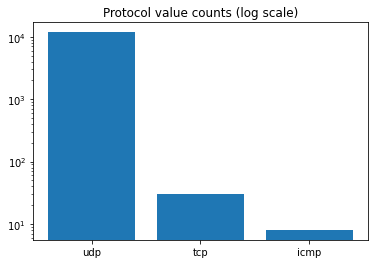

In [13]:
# Let's see what the frequency of each type of packet is
plt.yscale('log')
plt.title('Protocol value counts (log scale)')
plt.bar(df_10_inf_1.Proto.unique(), df_10_inf_1.Proto.value_counts())

<BarContainer object of 2 artists>

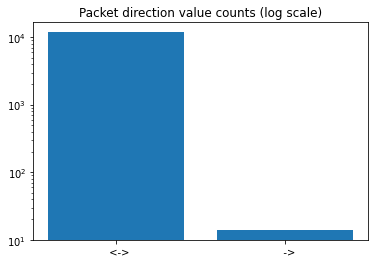

In [14]:
# frequency of each type of directional traffic
plt.yscale('log')
plt.title('Packet direction value counts (log scale)')
plt.bar(df_10_inf_1.Dir.unique(), df_10_inf_1.Dir.value_counts())

In [15]:
df_10_enc = df_10_inf_1.copy()
# df_10_enc.Dur = LabelEncoder().fit_transform(df_10_enc.Dur)
df_10_enc.Proto = LabelEncoder().fit_transform(df_10_enc.Proto)
df_10_enc.SrcAddr = LabelEncoder().fit_transform(df_10_enc.SrcAddr)
df_10_enc.Sport = LabelEncoder().fit_transform(df_10_enc.Sport.astype('str'))
df_10_enc.Dir = LabelEncoder().fit_transform(df_10_enc.Dir)
df_10_enc.DstAddr = LabelEncoder().fit_transform(df_10_enc.DstAddr.astype('str'))
df_10_enc.Dport = LabelEncoder().fit_transform(df_10_enc.Dport.astype('str'))
df_10_enc.State = LabelEncoder().fit_transform(df_10_enc.State.astype('str'))
df_10_enc.TotPkts = LabelEncoder().fit_transform(df_10_enc.TotPkts)
df_10_enc.TotBytes = LabelEncoder().fit_transform(df_10_enc.TotBytes)
df_10_enc.SrcBytes = LabelEncoder().fit_transform(df_10_enc.SrcBytes)


Botnet-ICMP    105977
Botnet-UDP        293
Botnet-TCP         82
Name: MetaLabel, dtype: int64


In [72]:
print(df_10_enc.MetaLabel.value_counts().to_string())

Botnet-ICMP    105977
Botnet-UDP        293
Botnet-TCP         82


In [17]:
df_10_enc['EncLabel'] = pd.Series()
# df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('Normal'))] = 0
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('ICMP'))] = 1
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('UDP'))] = 2
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('TCP'))] = 3

df_10_enc.EncLabel = df_10_enc.EncLabel.astype('int8')
df_10_enc.EncLabel

<ipython-input-17-36a56fe13de3>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10_enc['EncLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0        2
1        2
2        3
3        2
4        2
        ..
11869    3
11870    2
11871    3
11872    2
11873    2
Name: EncLabel, Length: 11874, dtype: int8

In [69]:
# might not want to blindly encode these:
df_10_enc.Label = LabelEncoder().fit_transform(df_10_enc.Label)
print(df_10_enc.MetaLabel.value_counts())

Botnet-ICMP    105977
Botnet-UDP        293
Botnet-TCP         82
Name: MetaLabel, dtype: int64


Botnet-ICMP    105977
Botnet-UDP        293
Botnet-TCP         82
Name: MetaLabel, dtype: int64


In [20]:
df_10_enc.head(10)

,index,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,TotPkts,TotBytes,SrcBytes,Label,MetaLabel,EncLabel
0,1473,0.000263,2,0,53,1,0,190,1,1,2,1,5,Botnet-UDP,2
1,1474,0.000401,2,0,53,1,0,190,1,1,6,4,5,Botnet-UDP,2
2,1475,0.075763,1,0,57,0,5,221,30,4,7,7,2,Botnet-TCP,3
3,1478,0.000450,2,0,53,1,0,190,1,1,4,2,5,Botnet-UDP,2
4,1479,3.017135,2,0,426,0,4,28,7,1,1,5,4,Botnet-UDP,2
5,1974,0.000465,2,0,53,1,0,190,1,1,5,2,5,Botnet-UDP,2
6,1975,3570.946045,1,0,68,0,9,205,28,51,33,12,1,Botnet-TCP,3
7,2492,0.000227,2,0,53,1,0,190,1,1,2,1,5,Botnet-UDP,2
8,2497,0.000384,2,0,53,1,0,190,1,1,3,3,5,Botnet-UDP,2
9,2498,60.004951,1,0,72,0,2,221,30,5,9,6,3,Botnet-TCP,3


### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

Text(0.5, 1.0, 'Correlation heat map')

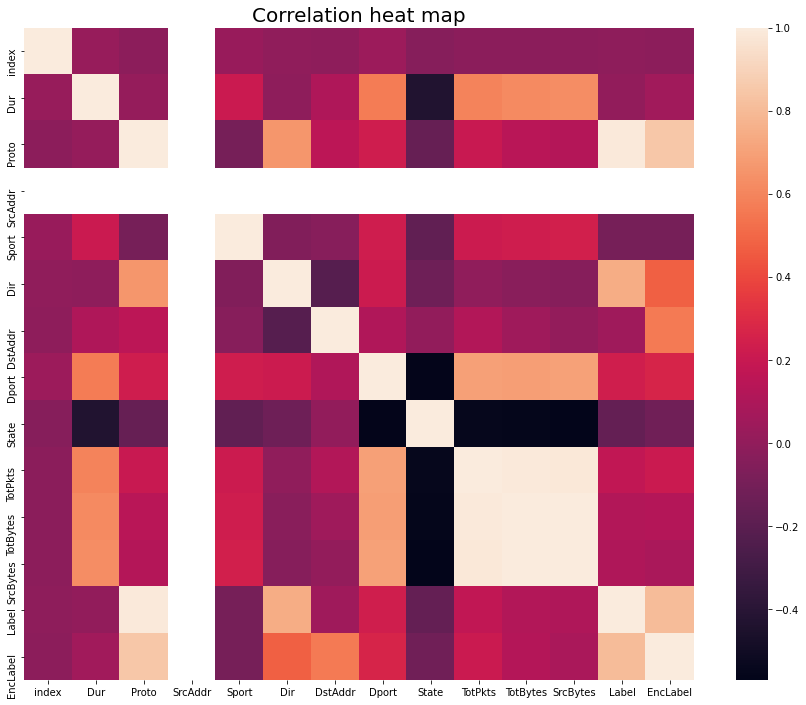

In [21]:
# Let's look at a correlation heatmap to see which are closely associated with target labels
fig = plt.figure(figsize=(15,12))
sns.heatmap(df_10_enc.corr())
plt.title('Correlation heat map', size=20)

Text(0.5, 1.0, 'Direction (blue) vs. Attack Type (yellow)')

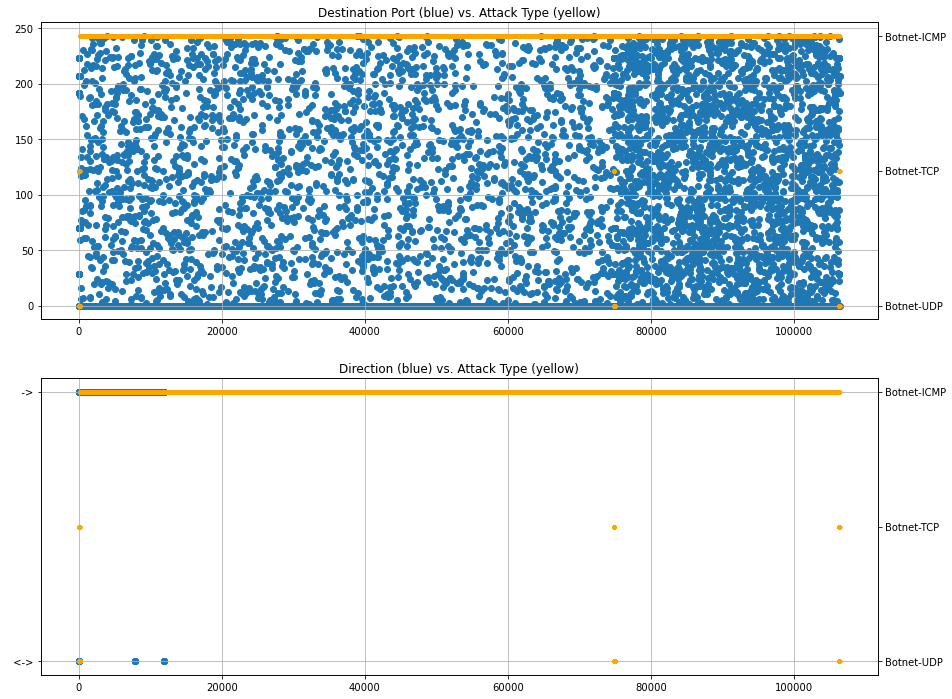

In [73]:
fig, (ax1, ax3) = plt.subplots(2,1,figsize=(15,12))


ax1.scatter(df_10_enc.index, df_10_enc.Dport, marker='o', alpha=1)
ax2 = ax1.twinx()
ax1.grid()
ax2.scatter(df_10_enc.index, df_10_enc.MetaLabel, marker=".", color='orange', alpha=1)
# ax1.legend(['Dport'], loc='upper left')
# ax2.legend(['Label'], loc='upper right')


ax3.scatter(df_10_inf_1.index, df_10_inf_1.Dir, marker='o', alpha=1)
ax4 = ax3.twinx()
ax3.grid()
ax4.scatter(df_10_enc.index, df_10_enc.MetaLabel, marker=".", color='orange', alpha=1)
# ax3.legend(['TotPkts'], loc='center left')
# ax4.legend(['Label'], loc='center right')

ax1.set_title('Destination Port (blue) vs. Attack Type (yellow)')
ax3.set_title('Direction (blue) vs. Attack Type (yellow)')



### 1b. Discretize selected features

As we see above, `Protocol` is most directly correlated with the encoded label. However, this is largely because `EncLabel` is a feature derived from `Protocol`, so we ignore it. Furthermore, the vast majority (>99%) of the values in `Proto` are `ICMP`, so the data is incredibly unbalanced.

The next highest correlation is `DstAddr`. Now, attackers can theoretically choose any target as a victim, so filtering destinations likely won't help us with a general model. 

Following that, the next highest correlation is `Dport`, but the vast majority of the dataset has been backfilled to `0` because most of the Dport values were `NaN`. This means that `Dir` and `TotPkts` are the next 2 most correlated features to the target labels.

Text(0.5, 1.0, 'Direction value counts (log scale)')

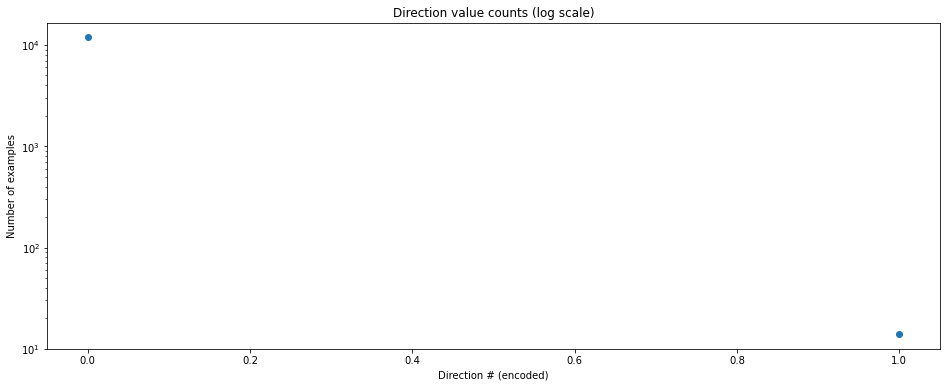

In [23]:
# Let's see the distribution of each encoded port:
fig = plt.figure(figsize=(16,6))
plt.yscale('log')
plt.scatter(df_10_enc.Dir.value_counts().sort_index().index.values, df_10_enc.Dir.value_counts().sort_index())
plt.ylabel('Number of examples')
plt.xlabel('Direction # (encoded)')
plt.title('Direction value counts (log scale)')

We see above that `DstAddr = 1` has far more attacks against it than any other port from this specific host.

Text(0.5, 1.0, 'Total number of packets value counts (log scale)')

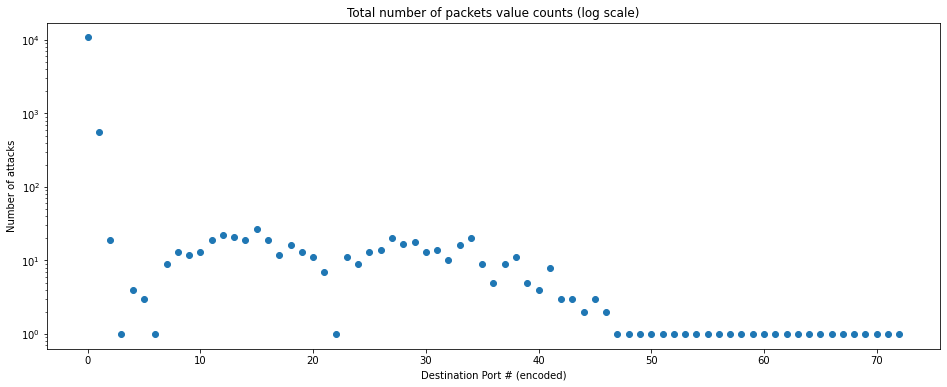

In [24]:
# Let's see the distribution of each encoded port:
fig = plt.figure(figsize=(16,6))
plt.yscale('log')
# sorted_counts = np.sort(df_10_enc.Dport.value_counts().index)
plt.scatter(df_10_enc.TotPkts.value_counts().sort_index().index.values, df_10_enc.TotPkts.value_counts().sort_index())
plt.ylabel('Number of attacks')
plt.xlabel('Destination Port # (encoded)')
plt.title('Total number of packets value counts (log scale)')

In [25]:
# We can see that Dport and Dir are the two most outstanding features with the Metalabel w.r.t. botnet behavior
# Let's combine these with the encoded labels

df_10_enc['DTP'] = df_10_enc.Dir.astype('str') + df_10_enc.TotPkts.astype('str')
df_10_enc.DTP = df_10_enc.DTP.astype('int32')
df_10_x = pd.concat([df_10_enc.DTP, df_10_enc.MetaLabel, df_10_enc.EncLabel], axis=1)

df_10_x.DTP.value_counts()

0     10793
1       540
11       33
15       27
12       22
      ...  
59        1
52        1
60        1
68        1
71        1
Name: DTP, Length: 73, dtype: int64

In [26]:
# Let's bin the values into 3 categories:
# '0' for the values where Dir and TotPkts = 0
# '1' for the values where Dir and TotPkts = 1
# '2' for the values where Dir and TotPkts > 1


df_10_x.DTP.loc[np.where(df_10_x.DTP == 0)] = 0
df_10_x.DTP.loc[np.where(df_10_x.DTP == 1)] = 1
df_10_x.DTP.loc[np.where(df_10_x.DTP > 1)] = 2

df_10_x.value_counts()

C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

DTP  MetaLabel    EncLabel
0    Botnet-ICMP  1           10790
1    Botnet-ICMP  1             537
2    Botnet-ICMP  1             509
     Botnet-UDP   2              24
     Botnet-TCP   3               8
0    Botnet-UDP   2               3
1    Botnet-UDP   2               3
dtype: int64

### 1b. Answers and explanation

Going off of correlation, many of the attributes with high correlation to attack labels are those that are difficult to generalize, e.g. `DstAddr` which are circumstantial, and `Dport` which was largely `NaN` and needed to be ignored. Therefore, we combined the attributes `Dir` and `TotPkts`, and binned them into three categories: `0`, `1`, and `2`.


## 2. Frequent task – 1/2 A4 (Individual)

### 2a. Use the SPACE SAVING algorithm

### 2b. Analysis and answers to the questions

## 3. Sketching task – 1/2 A4 (Individual) (Andrew)

### 3a. COUNT-MIN sketch


In [27]:
sha = hashlib.sha256()
sha.update(b"256")
sha.digest()

b'Q\xe8\xea(\x0bD\xe1i4\xd4\xd6\x11\x90\x1f=:\xfcAx\x98@\xac\xdf\xf8\x19B\xc2\xf6P\t\xcdR'

### 3b. Analysis and answers to the questions

## 4. Min-wise locality sensitive hashing task – 1/2 A4 (Individual)

### 4a. Implementation

### 4b. Analysis and answers to the questions

## 5. Random hyperplane locality sensitive hashing task – 1/2 A4 (Individual) (Andrew)

### 5a. Implementation - locality sensitive hashing

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Botnet profiling task – 1/2 A4

In [62]:
# We need all the datasets

df_9 = pd.read_csv('./dataset_9/capture20110817.binetflow')


# Engineer the data for each (the same way we did for df_9)
df_9.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_9.drop(index=np.where(df_9['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_9.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_9.reset_index(drop=True, inplace=True)

# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_9.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_9.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_9.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER


df_9.Dport = df_9.Dport.astype('str')
df_9.Sport = df_9.Sport.astype('str')
df_9.Dport = df_9.Dport.apply(lambda x: int(str(x), 0))
df_9.Sport = df_9.Sport.apply(lambda x: int(str(x), 0))



# Let's create a meta-label attribute for each protocol type for botnet activity
df_9['MetaLabel'] = pd.Series()
df_9.MetaLabel.loc[np.where(df_9.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_9.MetaLabel.loc[np.where(df_9.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_9.MetaLabel.loc[np.where(df_9.Label.str.contains('TCP'))] = 'Botnet-TCP'


df_9_inf = df_9.loc[np.where(df_9.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_9_enc = df_9_inf.copy()
# df_9_enc.Dur = LabelEncoder().fit_transform(df_9_enc.Dur)
df_9_enc.Proto = LabelEncoder().fit_transform(df_9_enc.Proto)
df_9_enc.SrcAddr = LabelEncoder().fit_transform(df_9_enc.SrcAddr)
df_9_enc.Sport = LabelEncoder().fit_transform(df_9_enc.Sport.astype('str'))
df_9_enc.Dir = LabelEncoder().fit_transform(df_9_enc.Dir)
df_9_enc.DstAddr = LabelEncoder().fit_transform(df_9_enc.DstAddr.astype('str'))
df_9_enc.Dport = LabelEncoder().fit_transform(df_9_enc.Dport.astype('str'))
df_9_enc.State = LabelEncoder().fit_transform(df_9_enc.State.astype('str'))
df_9_enc.TotPkts = LabelEncoder().fit_transform(df_9_enc.TotPkts)
df_9_enc.TotBytes = LabelEncoder().fit_transform(df_9_enc.TotBytes)
df_9_enc.SrcBytes = LabelEncoder().fit_transform(df_9_enc.SrcBytes)

df_9_enc['EncLabel'] = pd.Series()
df_9_enc.EncLabel.loc[np.where(df_9_enc.Label.str.contains('ICMP'))] = 1
df_9_enc.EncLabel.loc[np.where(df_9_enc.Label.str.contains('UDP'))] = 2
df_9_enc.EncLabel.loc[np.where(df_9_enc.Label.str.contains('TCP'))] = 3
df_9_enc.EncLabel = df_9_enc.EncLabel.astype('int8')


df_9_enc['DTP'] = df_9_enc.Dir.astype('str') + df_9_enc.TotPkts.astype('str')
df_9_enc.DTP = df_9_enc.DTP.astype('int32')
df_9_x = pd.concat([df_9_enc.SrcAddr, df_9_enc.DTP, df_9_enc.MetaLabel, df_9_enc.EncLabel], axis=1)


df_9_x

<ipython-input-62-9c942b2d8fe3>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_9['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-62-9c942b2d8fe3>:47: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_9_enc['EncLabel'] = pd.Series()


,SrcAddr,DTP,MetaLabel,EncLabel
0,0,11,Botnet-UDP,2
1,0,11,Botnet-UDP,2
2,0,6,Botnet-TCP,3
3,0,11,Botnet-UDP,2
4,0,1,Botnet-UDP,2
...,...,...,...,...
184982,6,11,Botnet-UDP,2
184983,6,11,Botnet-UDP,2
184984,6,11,Botnet-UDP,2
184985,6,11,Botnet-UDP,2


In [63]:
# We need all the datasets

df_10 = pd.read_csv('./dataset_10/capture20110818.binetflow')

# Engineer the data for each (the same way we did for df_10)
df_10.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_10.drop(index=np.where(df_10['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_10.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_10.reset_index(drop=True, inplace=True)

# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_10.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_10.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER


df_10.Dport = df_10.Dport.astype('str')
df_10.Sport = df_10.Sport.astype('str')
df_10.Dport = df_10.Dport.apply(lambda x: int(str(x), 0))
df_10.Sport = df_10.Sport.apply(lambda x: int(str(x), 0))



# Let's create a meta-label attribute for each protocol type for botnet activity
df_10['MetaLabel'] = pd.Series()
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_10.MetaLabel.loc[np.where(df_10.Label.str.contains('TCP'))] = 'Botnet-TCP'


df_10_inf = df_10.loc[np.where(df_10.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_10_enc = df_10_inf.copy()
# df_10_enc.Dur = LabelEncoder().fit_transform(df_10_enc.Dur)
df_10_enc.Proto = LabelEncoder().fit_transform(df_10_enc.Proto)
df_10_enc.SrcAddr = LabelEncoder().fit_transform(df_10_enc.SrcAddr)
df_10_enc.Sport = LabelEncoder().fit_transform(df_10_enc.Sport.astype('str'))
df_10_enc.Dir = LabelEncoder().fit_transform(df_10_enc.Dir)
df_10_enc.DstAddr = LabelEncoder().fit_transform(df_10_enc.DstAddr.astype('str'))
df_10_enc.Dport = LabelEncoder().fit_transform(df_10_enc.Dport.astype('str'))
df_10_enc.State = LabelEncoder().fit_transform(df_10_enc.State.astype('str'))
df_10_enc.TotPkts = LabelEncoder().fit_transform(df_10_enc.TotPkts)
df_10_enc.TotBytes = LabelEncoder().fit_transform(df_10_enc.TotBytes)
df_10_enc.SrcBytes = LabelEncoder().fit_transform(df_10_enc.SrcBytes)

df_10_enc['EncLabel'] = pd.Series()
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('ICMP'))] = 1
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('UDP'))] = 2
df_10_enc.EncLabel.loc[np.where(df_10_enc.Label.str.contains('TCP'))] = 3
df_10_enc.EncLabel = df_10_enc.EncLabel.astype('int8')


df_10_enc['DTP'] = df_10_enc.Dir.astype('str') + df_10_enc.TotPkts.astype('str')
df_10_enc.DTP = df_10_enc.DTP.astype('int32')
df_10_x = pd.concat([df_10_enc.SrcAddr, df_10_enc.DTP, df_10_enc.MetaLabel, df_10_enc.EncLabel], axis=1)


df_10_x

<ipython-input-63-35d89ae3e7b9>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-63-35d89ae3e7b9>:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_10_enc['EncLabel'] = pd.Series()


,SrcAddr,DTP,MetaLabel,EncLabel
0,0,11,Botnet-UDP,2
1,0,11,Botnet-UDP,2
2,0,6,Botnet-TCP,3
3,0,11,Botnet-UDP,2
4,0,3,Botnet-UDP,2
...,...,...,...,...
106347,0,0,Botnet-ICMP,1
106348,7,11,Botnet-UDP,2
106349,7,8,Botnet-TCP,3
106350,0,11,Botnet-UDP,2


In [64]:
# We need all the datasets

df_11 = pd.read_csv('./dataset_11/capture20110818-2.binetflow')

# Engineer the data for each (the same way we did for df_11)
df_11.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_11.drop(index=np.where(df_11['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_11.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_11.reset_index(drop=True, inplace=True)

# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_11.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_11.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_11.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER


df_11.Dport = df_11.Dport.astype('str')
df_11.Sport = df_11.Sport.astype('str')
df_11.Dport = df_11.Dport.apply(lambda x: int(str(x), 0))
df_11.Sport = df_11.Sport.apply(lambda x: int(str(x), 0))



# Let's create a meta-label attribute for each protocol type for botnet activity
df_11['MetaLabel'] = pd.Series()
df_11.MetaLabel.loc[np.where(df_11.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_11.MetaLabel.loc[np.where(df_11.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_11.MetaLabel.loc[np.where(df_11.Label.str.contains('TCP'))] = 'Botnet-TCP'


df_11_inf = df_11.loc[np.where(df_11.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_11_enc = df_11_inf.copy()
# df_11_enc.Dur = LabelEncoder().fit_transform(df_11_enc.Dur)
df_11_enc.Proto = LabelEncoder().fit_transform(df_11_enc.Proto)
df_11_enc.SrcAddr = LabelEncoder().fit_transform(df_11_enc.SrcAddr)
df_11_enc.Sport = LabelEncoder().fit_transform(df_11_enc.Sport.astype('str'))
df_11_enc.Dir = LabelEncoder().fit_transform(df_11_enc.Dir)
df_11_enc.DstAddr = LabelEncoder().fit_transform(df_11_enc.DstAddr.astype('str'))
df_11_enc.Dport = LabelEncoder().fit_transform(df_11_enc.Dport.astype('str'))
df_11_enc.State = LabelEncoder().fit_transform(df_11_enc.State.astype('str'))
df_11_enc.TotPkts = LabelEncoder().fit_transform(df_11_enc.TotPkts)
df_11_enc.TotBytes = LabelEncoder().fit_transform(df_11_enc.TotBytes)
df_11_enc.SrcBytes = LabelEncoder().fit_transform(df_11_enc.SrcBytes)

df_11_enc['EncLabel'] = pd.Series()
df_11_enc.EncLabel.loc[np.where(df_11_enc.Label.str.contains('ICMP'))] = 1
df_11_enc.EncLabel.loc[np.where(df_11_enc.Label.str.contains('UDP'))] = 2
df_11_enc.EncLabel.loc[np.where(df_11_enc.Label.str.contains('TCP'))] = 3
df_11_enc.EncLabel = df_11_enc.EncLabel.astype('int8')


df_11_enc['DTP'] = df_11_enc.Dir.astype('str') + df_11_enc.TotPkts.astype('str')
df_11_enc.DTP = df_11_enc.DTP.astype('int32')
df_11_x = pd.concat([df_11_enc.SrcAddr, df_11_enc.DTP, df_11_enc.MetaLabel, df_11_enc.EncLabel], axis=1)

df_11_x

<ipython-input-64-2ae05d24277b>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_11['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-64-2ae05d24277b>:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_11_enc['EncLabel'] = pd.Series()


,SrcAddr,DTP,MetaLabel,EncLabel
0,0,11,Botnet-UDP,2
1,0,11,Botnet-UDP,2
2,0,4,Botnet-TCP,3
3,0,11,Botnet-UDP,2
4,0,1,Botnet-UDP,2
...,...,...,...,...
8159,0,0,Botnet-ICMP,1
8160,0,0,Botnet-ICMP,1
8161,0,0,Botnet-ICMP,1
8162,0,0,Botnet-ICMP,1


In [65]:
# We need all the datasets

df_12 = pd.read_csv('./dataset_12/capture20110819.binetflow')

# Engineer the data for each (the same way we did for df_12)
df_12.drop("StartTime", axis=1, inplace=True) # Every value is different, time likely not an important factor
df_12.drop(index=np.where(df_12['Label'].str.contains("Background"))[0], inplace=True) # drop background traffic
df_12.drop(["sTos", "dTos"], axis=1, inplace=True) # only contains 1 value, and NaN
df_12.reset_index(drop=True, inplace=True)

# Fill the NaN values (ICMP packets are transport-layer, so they don't have a port number. Set the ports = 0)
df_12.Sport.fillna(value=0, inplace=True) # set the NaN port = 0
df_12.Dport.fillna(value=0, inplace=True) # set the NaN port = 0
df_12.State.fillna(value="OTHER", inplace=True) # Set the state to OTHER


df_12.Dport = df_12.Dport.astype('str')
df_12.Sport = df_12.Sport.astype('str')
df_12.Dport = df_12.Dport.apply(lambda x: int(str(x), 0))
df_12.Sport = df_12.Sport.apply(lambda x: int(str(x), 0))



# Let's create a meta-label attribute for each protocol type for botnet activity
df_12['MetaLabel'] = pd.Series()
df_12.MetaLabel.loc[np.where(df_12.Label.str.contains('ICMP'))] = 'Botnet-ICMP'
df_12.MetaLabel.loc[np.where(df_12.Label.str.contains('UDP'))] = 'Botnet-UDP'
df_12.MetaLabel.loc[np.where(df_12.Label.str.contains('TCP'))] = 'Botnet-TCP'


df_12_inf = df_12.loc[np.where(df_12.Label.str.contains('Botnet'))].reset_index(inplace=False)

df_12_enc = df_12_inf.copy()
# df_12_enc.Dur = LabelEncoder().fit_transform(df_12_enc.Dur)
df_12_enc.Proto = LabelEncoder().fit_transform(df_12_enc.Proto)
df_12_enc.SrcAddr = LabelEncoder().fit_transform(df_12_enc.SrcAddr)
df_12_enc.Sport = LabelEncoder().fit_transform(df_12_enc.Sport.astype('str'))
df_12_enc.Dir = LabelEncoder().fit_transform(df_12_enc.Dir)
df_12_enc.DstAddr = LabelEncoder().fit_transform(df_12_enc.DstAddr.astype('str'))
df_12_enc.Dport = LabelEncoder().fit_transform(df_12_enc.Dport.astype('str'))
df_12_enc.State = LabelEncoder().fit_transform(df_12_enc.State.astype('str'))
df_12_enc.TotPkts = LabelEncoder().fit_transform(df_12_enc.TotPkts)
df_12_enc.TotBytes = LabelEncoder().fit_transform(df_12_enc.TotBytes)
df_12_enc.SrcBytes = LabelEncoder().fit_transform(df_12_enc.SrcBytes)

df_12_enc['EncLabel'] = pd.Series()
df_12_enc.EncLabel.loc[np.where(df_12_enc.Label.str.contains('ICMP'))] = 1
df_12_enc.EncLabel.loc[np.where(df_12_enc.Label.str.contains('UDP'))] = 2
df_12_enc.EncLabel.loc[np.where(df_12_enc.Label.str.contains('TCP'))] = 3
df_12_enc.EncLabel = df_12_enc.EncLabel.astype('int8')


df_12_enc['DTP'] = df_12_enc.Dir.astype('str') + df_12_enc.TotPkts.astype('str')
df_12_enc.DTP = df_12_enc.DTP.astype('int32')
df_12_x = pd.concat([df_12_enc.SrcAddr, df_12_enc.DTP, df_12_enc.MetaLabel, df_12_enc.EncLabel], axis=1)


df_12_x

<ipython-input-65-1bc3db78e95c>:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_12['MetaLabel'] = pd.Series()
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-65-1bc3db78e95c>:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_12_enc['EncLabel'] = pd.Series()


,SrcAddr,DTP,MetaLabel,EncLabel
0,0,11,Botnet-UDP,2
1,0,11,Botnet-UDP,2
2,0,6,Botnet-TCP,3
3,0,11,Botnet-UDP,2
4,0,9,Botnet-TCP,3
...,...,...,...,...
2163,0,11,Botnet-UDP,2
2164,0,12,Botnet-UDP,2
2165,1,1,Botnet-UDP,2
2166,0,11,Botnet-UDP,2


In [66]:
df_x = pd.concat([df_9_x, df_10_x, df_11_x, df_12_x], axis=0, ignore_index=True)
df_x

,SrcAddr,DTP,MetaLabel,EncLabel
0,0,11,Botnet-UDP,2
1,0,11,Botnet-UDP,2
2,0,6,Botnet-TCP,3
3,0,11,Botnet-UDP,2
4,0,1,Botnet-UDP,2
...,...,...,...,...
301666,0,11,Botnet-UDP,2
301667,0,12,Botnet-UDP,2
301668,1,1,Botnet-UDP,2
301669,0,11,Botnet-UDP,2


In [54]:
# We can see the distribution of our discretized DDTP values, some of which are significantly higher in numerical value
df_x.DTP.value_counts()

0       127157
11      107369
2        16001
1        14636
5         7549
         ...  
325          1
1161         1
323          1
394          1
406          1
Name: DTP, Length: 502, dtype: int64

In [58]:
# Let's bin these into the top 3 categories as we did in exercise 1: 0, 1, and 2.

df_x.DTP.loc[np.where(df_x.DTP == 0)] = 0
df_x.DTP.loc[np.where(df_x.DTP == 11)] = 1
df_x.DTP.loc[np.where(df_x.DTP > 1)] = 2

C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\envs\lab\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [59]:
# A bit more balanced
df_x.DTP.value_counts()

0    127157
1    122005
2     52509
Name: DTP, dtype: int64

### 6a. Learn a sequential model

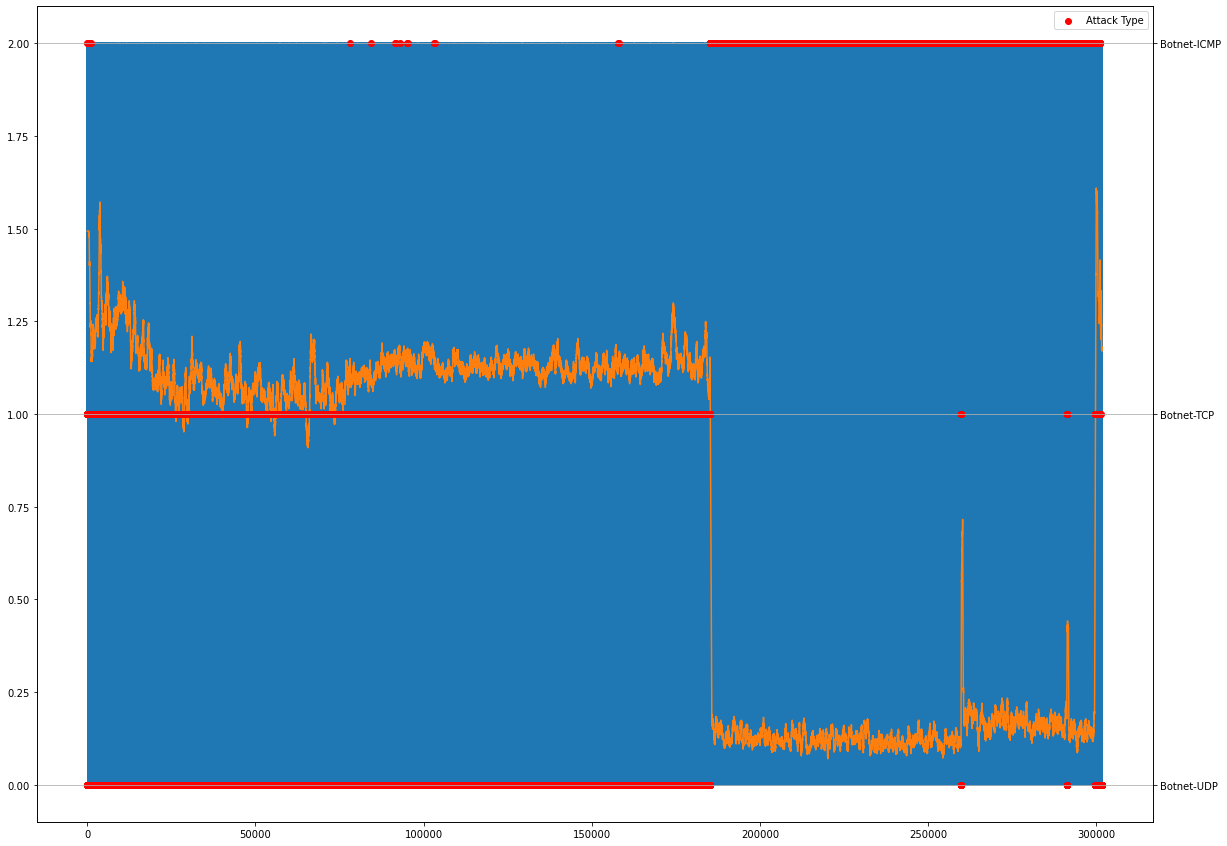

In [60]:
# We can see below that there's a dramatic shift when the botnet starts receiving ICMP packets. 
fig, ax = plt.subplots(figsize=(20,15))

df_x['DTP_500'] = pd.Series(df_x.DTP.rolling(window=500).mean()).fillna(method='bfill')
ax1 = ax.twinx()
ax1.grid()
ax.plot(df_x.DTP)
ax.plot(df_x.DTP_500)

ax1.scatter(df_x.index, df_x.MetaLabel, color='red')
ax1.legend(['Attack Type'])

### 6b. Analysis and answers to the questions.

## 7.Botnet fingerprinting task – 1/2 A4

### 7a. Fingerprinting


### 7b. Analysis and answers to the questions.

## 8. Bonus Task 1/2 A4

### 8a. Provide implementation and analysis.